In [1]:
from matplotlib import rc, animation
import numpy as np
from pysteps.utils import spectral
from diffusers import DDPMScheduler
from datetime import datetime
import matplotlib.pyplot as plt

Pysteps configuration file found at: c:\Users\marli\miniconda3\envs\gen_ai\lib\site-packages\pysteps\pystepsrc



c:\Users\marli\miniconda3\envs\gen_ai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_files = 6  # Adjust this number for the actual number of files
data_path_template = 'data/processed_sst_data{}.npy'
mask_path_template = 'data/sst_masks{}.npy'

data_paths = [data_path_template.format(i) for i in range(num_files)]
mask_paths = [mask_path_template.format(i) for i in range(num_files)]

min_val = 999
max_val = 0
for data_path, mask_path in zip(data_paths, mask_paths):
    sst_data = np.load(data_path)  # Shape: (time, lat, lon)
    min_val = min(min_val, np.min(sst_data[sst_data!=0]))
    max_val = max(max_val, np.max(sst_data))
    
print(min_val)
print(max_val)

4.5899997
33.5


(15762, 64, 64)


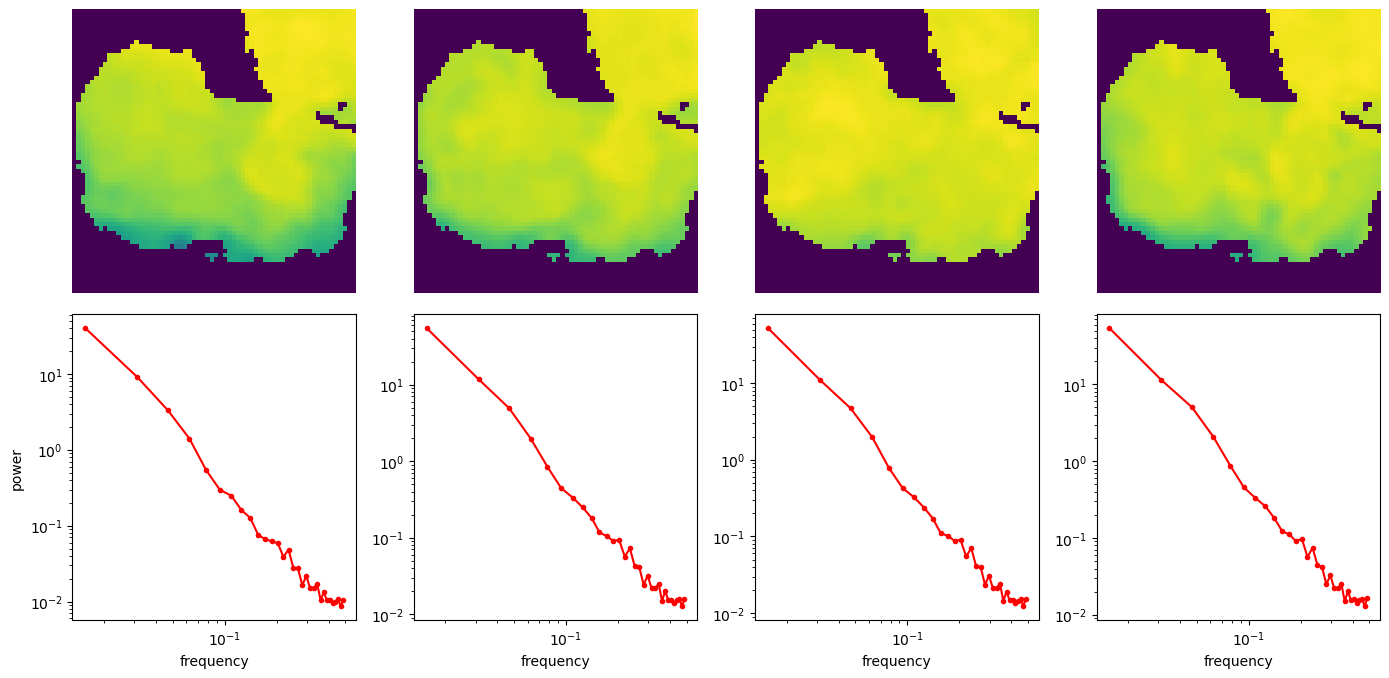

In [3]:
start_date = datetime.strptime("2000-01-02", "%Y-%m-%d")
images = np.stack([np.load(p) for p in data_paths], axis=0)[0]
print(images.shape)
num_displayed_examples = 4  # Set to fit within a 2x4 grid
plt.figure(figsize=(14, 7))
for k in range(0, num_displayed_examples):
    plt.subplot(2, 4, k+1)
    plt.imshow((images[50*k] + 1) / 2)
    plt.axis('off')

for k in range(0, num_displayed_examples):
    j = 100*k
    
    target_img = images[j]
    target_img = (target_img - 4.5899997) / (33.5 - 4.5899997)
    target_img = np.nan_to_num(target_img, nan=0.0)

    
    images[j] = np.nan_to_num(target_img, nan=0.0)
    rapsd, frequencies = spectral.rapsd(np.array(images)[j], fft_method=np.fft, return_freq=True)
    plt.subplot(2, 4, 4 + k + 1)
    plt.plot(frequencies[1:], rapsd[1:], c='red', marker='o', markersize=3)  # Chop off the DC component.
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('frequency')
    if k == 0:
        plt.ylabel('power')

plt.tight_layout()
plt.show()

In [4]:
def calc_mean_log_rapsd_masked(x, mask, noise_baseline):
    spectra = []
        
    # Process actual data
    for img in x:
        masked_img = img * mask
        rapsd, frequencies = spectral.rapsd(masked_img, fft_method=np.fft, return_freq=True)
        
        # Normalize by noise baseline if requested
        rapsd = rapsd / (noise_baseline + 1e-30)
            
        spectra.append(rapsd)
    
    mean_log_rapsd = np.mean(np.log(np.array(spectra) + 1e-30), axis=0)
    return mean_log_rapsd, frequencies

In [5]:
# Enable animation display in Jupyter Notebook
rc('animation', html='jshtml')

main_images = images#images[31:] - images[:-31]#images#[0]
num_steps = 7
cycles_per_sec = 0.2
selected_image_idx = 1
scheduler = DDPMScheduler(num_train_timesteps=1000, prediction_type="x0")

In [6]:
print(main_images.shape)

(15762, 64, 64)


0
100
200
300
400
500
600
700
800
900
done


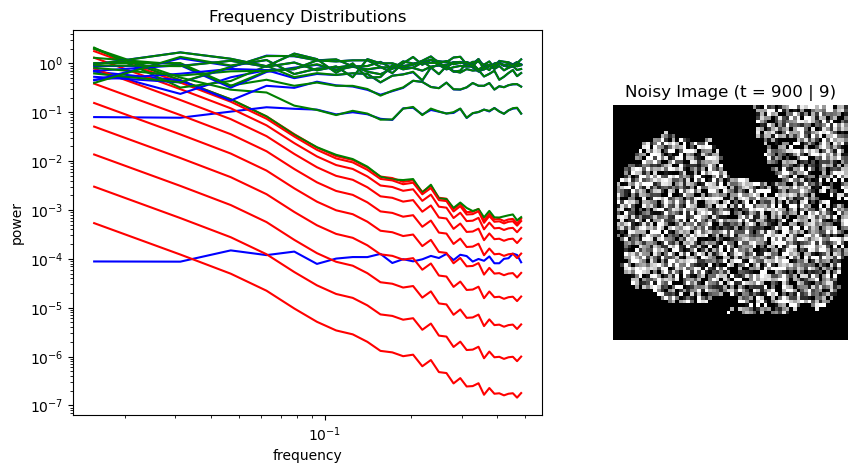

In [20]:
# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[2, 1])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('frequency')
ax1.set_ylabel('power')
ax1.set_title('Frequency Distributions')
title_artist = ax2.set_title('Noisy Image')  # Initial title
ax2.axis('off')

target_image = main_images[selected_image_idx]
target_image[target_image == 0] = -1
Mask = target_image != -1

target_image[Mask] = (target_image[Mask] - 4.5899997) / (33.5 - 4.5899997)

noise_spectra = []
for _ in range(100):
    noise = np.random.normal(0, 1, target_image.shape)
    masked_noise = noise * Mask
    noise_rapsd, _ = spectral.rapsd(masked_noise, fft_method=np.fft, return_freq=True)
    noise_spectra.append(noise_rapsd)
noise_baseline = np.mean(noise_spectra, axis=0)

# Prepare animation
artists = []
for i, t in enumerate(range(0, scheduler.config.num_train_timesteps, 100)):#3
    print(t)
    sqrt_alpha_prod = (scheduler.alphas_cumprod[t] ** 0.5).item()
    sqrt_one_minus_alpha_prod = ((1 - scheduler.alphas_cumprod[t]) ** 0.5).item()
    
    # Generate noise and noisy images
    current_noise = sqrt_one_minus_alpha_prod * np.random.randn(*images.shape[1:])
    current_noise[target_image == -1] = -1
    current_image = sqrt_alpha_prod * target_image
    current_image[target_image == -1] = -1
    
    noisy_images = current_image + current_noise
    
    # Calculate RAPSD
    mean_log_rapsd_noise, frequencies = calc_mean_log_rapsd_masked([current_noise], Mask, noise_baseline)
    mean_log_rapsd_noisy, _ = calc_mean_log_rapsd_masked([noisy_images], Mask, noise_baseline)
    mean_log_rapsd_base, _ = calc_mean_log_rapsd_masked([current_image], Mask, noise_baseline)

    # Plot the frequency distributions
    noise_line, = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_noise)[1:], 'blue', label='Noise' if i == 0 else "")
    base_line, = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_base)[1:], 'red', label='Image' if i == 0 else "")
    noisy_line, = ax1.plot(frequencies[1:], np.exp(mean_log_rapsd_noisy)[1:], 'green', label='Noisy Image' if i == 0 else "")

    # Show the noisy image
    img_artist = ax2.imshow(np.clip((noisy_images + 1) / 2, 0, 1), cmap='gray', animated=True)
    
    # Update the title
    title_artist.set_text(f'Noisy Image (t = {t} | {i})')

    # Collect artists for animation, including the title
    artists.append([noise_line, noisy_line, base_line, img_artist, title_artist])
print("done")

In [21]:
# Add a legend to the first frame
if artists:
    ax1.legend()

# Create the animation
anim = animation.ArtistAnimation(fig, artists, interval=1000 / (num_steps * cycles_per_sec), blit=False)

anim

In [26]:
# Set up the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), width_ratios=[2, 1])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('frequency')
ax1.set_ylabel('power')
ax1.set_title('Frequency Distributions')
ax2.axis('off')

target_image = main_images[selected_image_idx]
target_image[target_image == 0] = -1
Mask = target_image != -1

target_image[Mask] = (target_image[Mask] - 4.5899997) / (33.5 - 4.5899997)

noise_spectra = []
for _ in range(100):
    noise = np.random.normal(0, 1, target_image.shape)
    masked_noise = noise * Mask
    noise_rapsd, _ = spectral.rapsd(masked_noise, fft_method=np.fft, return_freq=True)
    noise_spectra.append(noise_rapsd)
noise_baseline = np.mean(noise_spectra, axis=0)

# Prepare animation
artists = []
frames = []
timesteps = range(0, scheduler.config.num_train_timesteps, 3)

for i, t in enumerate(timesteps):
    sqrt_alpha_prod = (scheduler.alphas_cumprod[t] ** 0.5).item()
    sqrt_one_minus_alpha_prod = ((1 - scheduler.alphas_cumprod[t]) ** 0.5).item()
    
    # Generate noise and noisy images
    current_noise = sqrt_one_minus_alpha_prod * np.random.randn(*images.shape[1:])
    current_noise[target_image == -1] = -1
    current_image = sqrt_alpha_prod * target_image
    current_image[target_image == -1] = -1
    
    noisy_images = current_image + current_noise
    
    # Calculate RAPSD
    mean_log_rapsd_noise, frequencies = calc_mean_log_rapsd_masked([current_noise], Mask, noise_baseline)
    mean_log_rapsd_noisy, _ = calc_mean_log_rapsd_masked([noisy_images], Mask, noise_baseline)
    mean_log_rapsd_base, _ = calc_mean_log_rapsd_masked([current_image], Mask, noise_baseline)
    
    frames.append({
        'frequencies': frequencies[1:],
        'noise_rapsd': np.exp(mean_log_rapsd_noise)[1:],
        'base_rapsd': np.exp(mean_log_rapsd_base)[1:],
        'noisy_rapsd': np.exp(mean_log_rapsd_noisy)[1:],
        'noisy_image': noisy_images,
        't': t
    })

# Initialize the first frame
first_frame = frames[0]
noise_line, = ax1.plot(first_frame['frequencies'], first_frame['noise_rapsd'], 'blue', label='Noise')
base_line, = ax1.plot(first_frame['frequencies'], first_frame['base_rapsd'], 'red', label='Image')
noisy_line, = ax1.plot(first_frame['frequencies'], first_frame['noisy_rapsd'], 'green', label='Noisy Image')
img_display = ax2.imshow(np.clip((first_frame['noisy_image'] + 1) / 2, 0, 1), cmap='gray')
ax1.legend()

def update(frame_idx):
    frame = frames[frame_idx]
    
    # Update lines
    noise_line.set_data(frame['frequencies'], frame['noise_rapsd'])
    base_line.set_data(frame['frequencies'], frame['base_rapsd'])
    noisy_line.set_data(frame['frequencies'], frame['noisy_rapsd'])
    
    # Update image
    img_display.set_array(np.clip((frame['noisy_image'] + 1) / 2, 0, 1))
    
    # Update title
    ax2.set_title(f'Noisy Image (t={frame["t"]})')
    
    return noise_line, base_line, noisy_line, img_display

# Create animation
anim = animation.FuncAnimation(
    fig, 
    update, 
    frames=len(frames),
    interval=1000 / (len(timesteps) * cycles_per_sec),
    blit=False
)

plt.close()
anim